<h1>Text Sentiment Analysis for Twitter Posts</h1>

Objective:
- Find out the different sentiment levels (negative, neutral, positive) among the posts and generate word clouds to discover key motivations / beliefs driving the sentiments

In [1]:
# pip install vaderSentiment

In [2]:
# pip install boto3

In [3]:
# pip install seaborn --upgrade

In [4]:
import pandas as pd
import numpy as np
import os
import re
import plotly.express as px
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.style as style
import matplotlib
import matplotlib.pyplot as plt
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jlrqq/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:
analyser = SentimentIntensityAnalyzer()

In [6]:
# https://github.com/cjhutto/vaderSentiment#about-the-scoring
# positive sentiment: compound score >= 0.05
# neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
# negative sentiment: compound score <= -0.05

def sentiment_analyzer_score(sentence):
    score = analyser.polarity_scores(sentence)
    return score['compound']

In [7]:
# Read Twitter Data from Local CSV

tweets = pd.read_csv('../Twitter_Data/Twitter_Mar_5000.csv', index_col=0)

print(tweets.shape)
tweets.head()

(5001, 5)


,Tweet Id,Text,Username,Coordinates,Place
Datetime,,,,,
2020-03-29 23:59:29+00:00,1244413906195484672,my partner got an AxiDraw shortly before covid...,JFriedhoff,NaN,NaN
2020-03-29 23:58:54+00:00,1244413758971273216,Lets ask @Tuface__idibia who is more closer to...,Braxcool,NaN,NaN
2020-03-29 23:58:24+00:00,1244413629811884034,With this lockdown we will all end up mental o...,ONELOVEAVFC,NaN,NaN
2020-03-29 23:58:18+00:00,1244413607720275969,Sekarang saya amati yg bertentangan adalah pem...,Raden_ahsan,NaN,NaN
2020-03-29 23:57:58+00:00,1244413522576060421,‼️WHOA. &gt;3.38 billion people worldwide are ...,DrDenaGrayson,NaN,NaN


In [8]:
# Read Twitter Data from S3 

# import pandas as pd
# import boto3
# import io

# AWS_ACCESS_KEY_ID = "*"
# AWS_SECRET_ACCESS_KEY = "*"
# bucket = "is434-last-sem-best-sem"
# file_name = "data-lake/tweeter_data.csv"

# # Create connection to S3 and all buckets within S3
# s3 = boto3.client(
#     's3',
#     aws_access_key_id=AWS_ACCESS_KEY_ID,
#     aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
# )

# # Get object and file (key) from bucket
# obj = s3.get_object(Bucket= bucket, Key= file_name) 

# tweets = pd.read_csv(io.BytesIO(obj['Body'].read()))
# tweets

In [9]:
# Extract Text from DataFrame into a List

tweet_text_list = tweets['Text'].tolist()
tweet_text_list

['my partner got an AxiDraw shortly before covid19 crushed nyc, which is great because when people ask me what he’s up to during lockdown, i can say “oh, he spends all day plotting”',
 'Lets ask @Tuface__idibia who is more closer to us d masses ..\n\nOga tubaba pls which acct did u send your 10mill ?\nE get reason 😁\n\n#COVID19\n#WhenCoronaVirusIsOver \n#lockdown',
 'With this lockdown we will all end up mental or Alcoholics 😢 #coronavirus #COVID19',
 'Sekarang saya amati yg bertentangan adalah pemerintah pusat yg melarang lockdown dan pemerintah daerah yg ngotot menerapkan lockdown lokal (isolasi wilayah) #covid19',
 '‼️WHOA. &gt;3.38 billion people worldwide are under #lockdown to limit the spread of #coronavirus, per @AFP.\n\nThis represents **43% of the TOTAL world population**.\n\n#COVID19 #CoronavirusPandemic \nhttps://t.co/WuicgMN9zr',
 '@joaomatoso2 #Wuhan residents estimate, based on calculations of cremations and urns now being returned to families, that between 42k-46k (!!) 

In [10]:
# Clean Text Function

def clean_tweet(comments):

    test_sentences = sent_tokenize(comments)
    test_sentences

    tokenizer = RegexpTokenizer(r'\w+')
    test_words = tokenizer.tokenize(comments)
    test_words_lower = list(map(lambda x: x.lower(), test_words)) 

    stop_words = stopwords.words('english')
    # print(stop_words)
    stop_words2 = ['co', 'covid', 'covid19', 'coronavirus', 'lockdown', 'covid19 lockdown', '&amp', 'amp']

    filtered_test_words = []

    for w in test_words_lower:
        if w not in stop_words and w not in stop_words2:
            filtered_test_words.append(w)

    porter_stemer = PorterStemmer()

    stemed_filter_test_words = []
    for i in filtered_test_words:
        stemed_filter_test_words.append(porter_stemer.stem(i))

    join_words = " ".join([x for x in stemed_filter_test_words])

    return join_words

In [11]:
# Extract processed text

processed_text = [clean_tweet(tw) for tw in tweet_text_list]
processed_text

['partner got axidraw shortli crush nyc great peopl ask say oh spend day plot',
 'let ask tuface__idibia closer us mass oga tubaba pl acct u send 10mill e get reason whencoronavirusisov',
 'end mental alcohol',
 'sekarang saya amati yg bertentangan adalah pemerintah pusat yg melarang dan pemerintah daerah yg ngotot menerapkan lokal isolasi wilayah',
 'whoa gt 3 38 billion peopl worldwid limit spread per afp repres 43 total world popul coronaviruspandem http wuicgmn9zr',
 'joaomatoso2 wuhan resid estim base calcul cremat urn return famili 42k 46k die citi surround area 2 5 month far offici figur 2535 death http cagsnpztei',
 'scottgottlieb top prioriti end resum seminorm life 1 build sentinel surveil system diseas track 2 rapid reliabl free test detect case 3 serolog antibodi test identifi immun http 7vdeda8ojc via wsj',
 'let hope wipe barcelona airport hapless attack smash car virtual empti termin amid sun http haujkyyvpw',
 'join live tomorrow fun free info eat shrink merri start mon

In [12]:
# Add processed text into the DataFrame

tweets['processed_text'] = processed_text

In [13]:
# Extract processed tweets column

tweets_list = tweets['processed_text'].tolist()
tweets_list[:10]

['partner got axidraw shortli crush nyc great peopl ask say oh spend day plot',
 'let ask tuface__idibia closer us mass oga tubaba pl acct u send 10mill e get reason whencoronavirusisov',
 'end mental alcohol',
 'sekarang saya amati yg bertentangan adalah pemerintah pusat yg melarang dan pemerintah daerah yg ngotot menerapkan lokal isolasi wilayah',
 'whoa gt 3 38 billion peopl worldwid limit spread per afp repres 43 total world popul coronaviruspandem http wuicgmn9zr',
 'joaomatoso2 wuhan resid estim base calcul cremat urn return famili 42k 46k die citi surround area 2 5 month far offici figur 2535 death http cagsnpztei',
 'scottgottlieb top prioriti end resum seminorm life 1 build sentinel surveil system diseas track 2 rapid reliabl free test detect case 3 serolog antibodi test identifi immun http 7vdeda8ojc via wsj',
 'let hope wipe barcelona airport hapless attack smash car virtual empti termin amid sun http haujkyyvpw',
 'join live tomorrow fun free info eat shrink merri start mon

In [14]:
# Get a list of sentiment scores for tweets

sentiment_score_list = []
for sentence in tweets_list:
    sentiment_score = sentiment_analyzer_score(str(sentence))
    sentiment_score_list.append(sentiment_score)

sentiment_score_list[:10]

[0.5423, 0.0, 0.0, 0.0, 0.2732, -0.8316, 0.6249, -0.3818, 0.875, 0.0]

In [15]:
# Add 'sentiment_score' column

tweets['sentiment_score'] = sentiment_score_list
tweets.head()

,Tweet Id,Text,Username,Coordinates,Place,processed_text,sentiment_score
Datetime,,,,,,,
2020-03-29 23:59:29+00:00,1244413906195484672,my partner got an AxiDraw shortly before covid...,JFriedhoff,NaN,NaN,partner got axidraw shortli crush nyc great pe...,0.5423
2020-03-29 23:58:54+00:00,1244413758971273216,Lets ask @Tuface__idibia who is more closer to...,Braxcool,NaN,NaN,let ask tuface__idibia closer us mass oga tuba...,0.0000
2020-03-29 23:58:24+00:00,1244413629811884034,With this lockdown we will all end up mental o...,ONELOVEAVFC,NaN,NaN,end mental alcohol,0.0000
2020-03-29 23:58:18+00:00,1244413607720275969,Sekarang saya amati yg bertentangan adalah pem...,Raden_ahsan,NaN,NaN,sekarang saya amati yg bertentangan adalah pem...,0.0000
2020-03-29 23:57:58+00:00,1244413522576060421,‼️WHOA. &gt;3.38 billion people worldwide are ...,DrDenaGrayson,NaN,NaN,whoa gt 3 38 billion peopl worldwid limit spre...,0.2732


In [16]:
# Label sentiments (positive, negative, neutral) based on sentiment_score for each tweet

tweets['sentiment_score'].apply(lambda x: float(x))
tweets['sentiment_label'] = 'NA'
tweets.loc[tweets.sentiment_score == 0, 'sentiment_label'] = 'neutral'
tweets.loc[tweets.sentiment_score < 0, 'sentiment_label'] = 'negative'
tweets.loc[tweets.sentiment_score > 0, 'sentiment_label'] = 'positive'

tweets.head()

,Tweet Id,Text,Username,Coordinates,Place,processed_text,sentiment_score,sentiment_label
Datetime,,,,,,,,
2020-03-29 23:59:29+00:00,1244413906195484672,my partner got an AxiDraw shortly before covid...,JFriedhoff,NaN,NaN,partner got axidraw shortli crush nyc great pe...,0.5423,positive
2020-03-29 23:58:54+00:00,1244413758971273216,Lets ask @Tuface__idibia who is more closer to...,Braxcool,NaN,NaN,let ask tuface__idibia closer us mass oga tuba...,0.0000,neutral
2020-03-29 23:58:24+00:00,1244413629811884034,With this lockdown we will all end up mental o...,ONELOVEAVFC,NaN,NaN,end mental alcohol,0.0000,neutral
2020-03-29 23:58:18+00:00,1244413607720275969,Sekarang saya amati yg bertentangan adalah pem...,Raden_ahsan,NaN,NaN,sekarang saya amati yg bertentangan adalah pem...,0.0000,neutral
2020-03-29 23:57:58+00:00,1244413522576060421,‼️WHOA. &gt;3.38 billion people worldwide are ...,DrDenaGrayson,NaN,NaN,whoa gt 3 38 billion peopl worldwid limit spre...,0.2732,positive


In [17]:
# Get number of tweets for each sentiment

tweets_per_sentiment = tweets.groupby(['sentiment_label']).size().reset_index(name='num_posts')
tweets_per_sentiment

,sentiment_label,num_posts
0,negative,1165
1,neutral,2086
2,positive,1750


In [18]:
tweets_per_sentiment['percentage_of_total'] = tweets_per_sentiment['num_posts'].apply(lambda x: round(x / tweets.shape[0], 2) * 100)
tweets_per_sentiment

,sentiment_label,num_posts,percentage_of_total
0,negative,1165,23.0
1,neutral,2086,42.0
2,positive,1750,35.0


In [19]:
# List for tweets with 0.0 sentiments

unwanted_index = []

In [20]:
# Retrieve tweets with 0.0 sentiments

for index, row in tweets.iterrows():
    if row['sentiment_score'] == 0.0:
        unwanted_index.append(index)

In [21]:
# Number of tweets with 0.0 sentiments

len(unwanted_index)

2086

In [22]:
# Final tweets DataFrame

final_tweets = tweets.drop(unwanted_index)

In [23]:
# Preview final tweets DataFrame

final_tweets

,Tweet Id,Text,Username,Coordinates,Place,processed_text,sentiment_score,sentiment_label
Datetime,,,,,,,,
2020-03-29 23:59:29+00:00,1244413906195484672,my partner got an AxiDraw shortly before covid...,JFriedhoff,NaN,NaN,partner got axidraw shortli crush nyc great pe...,0.5423,positive
2020-03-29 23:57:58+00:00,1244413522576060421,‼️WHOA. &gt;3.38 billion people worldwide are ...,DrDenaGrayson,NaN,NaN,whoa gt 3 38 billion peopl worldwid limit spre...,0.2732,positive
2020-03-29 23:57:00+00:00,1244413279419629572,"@joaomatoso2 #Wuhan residents estimate, based ...",semlimites1980,NaN,NaN,joaomatoso2 wuhan resid estim base calcul crem...,-0.8316,negative
2020-03-29 23:56:52+00:00,1244413243663269888,@scottgottlieb on top priorities to end #COVID...,EdBelongia,NaN,NaN,scottgottlieb top prioriti end resum seminorm ...,0.6249,positive
2020-03-29 23:54:57+00:00,1244412761460879360,Let's hope #Covid19 wipes them all out.\n👇\nBa...,johnriley1990,NaN,NaN,let hope wipe barcelona airport hapless attack...,-0.3818,negative
...,...,...,...,...,...,...,...,...
2020-03-29 08:32:46+00:00,1244180687894261760,Just wanted to ask Indians that how is the Loc...,SSGroupPAK,NaN,NaN,want ask indian iokcurfewed_worldlock mannkiba...,0.0772,positive
2020-03-29 08:32:25+00:00,1244180598236692481,Ready to hit the road! Hundreds of #highspeed ...,marketsday,NaN,NaN,readi hit road hundr highspe bullet train stan...,0.0258,positive
2020-03-29 08:32:16+00:00,1244180562828341248,Wave 1: More cases and deaths in coming days -...,HemanthPadmakar,NaN,NaN,wave 1 case death come day us like cross 200 0...,-0.3400,negative


In [24]:
# Preview desc stats of final tweets DataFrame

final_tweets.describe()

,Tweet Id,sentiment_score
count,2.813000e+03,2813.000000
mean,1.244287e+18,0.088743
std,6.363420e+13,0.513599
min,1.244180e+18,-0.961200
25%,1.244231e+18,-0.381800
50%,1.244288e+18,0.202300
75%,1.244338e+18,0.493900
max,1.244414e+18,0.969000


In [25]:
# import seaborn as sns

In [26]:
# res = pd.Series(final_tweets['sentiment_score'], name="sentiment_score")
# print(res)
# plt = sns.distplot(res)
# plt

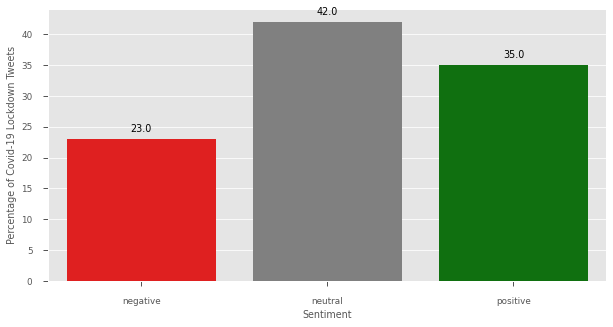

In [27]:
# Visualise percentage of posts with each sentiment

#### Plot settings ####
style.use('seaborn-poster') # sets the size of the charts
style.use('ggplot')
matplotlib.rcParams['font.family'] = "DejaVu Sans"
plt.rcParams['figure.figsize'] = [10, 5]
sns.set_context('paper')

cols = ['red' if label == 'negative' else ('green' if label == 'positive' else 'gray') for label in tweets_per_sentiment['sentiment_label']]
ax = sns.barplot(x="sentiment_label",
                 y="percentage_of_total",
                 data=tweets_per_sentiment,
                 palette=cols
                )

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

ax.set(xlabel='Sentiment', ylabel='Percentage of Covid-19 Lockdown Tweets')

plt.savefig('../Twitter_Output/Twitter_Mar_SentimentChart.png', dpi=400, bbox_inches="tight")

In [28]:
# Word Cloud Function

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def generate_word_cloud(dataframe, category):
    comment_words = ''
    processed_text = dataframe['processed_text']
    
    # iterate through list
    for tweet_text in processed_text:
        # split the text into tokens
        tokens = tweet_text.split()
        # Append tokens to string comment_words
        comment_words += " ".join(tokens)+" "

    # make a word cloud
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='black', colormap='rainbow',
                    #stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)

    # plot the word cloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.show()
    wordcloud.to_file(f'../Twitter_Output/Twitter_Mar_Wordcloud_{category}.png')

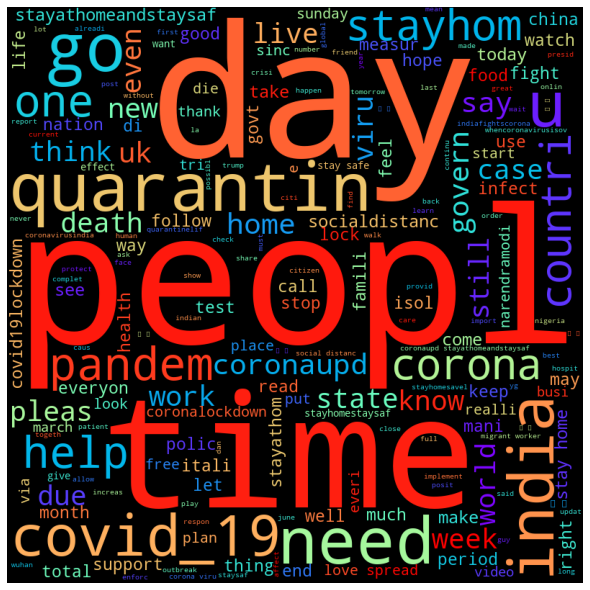

In [29]:
# All Sentiment Word Cloud

generate_word_cloud(tweets, 'all')

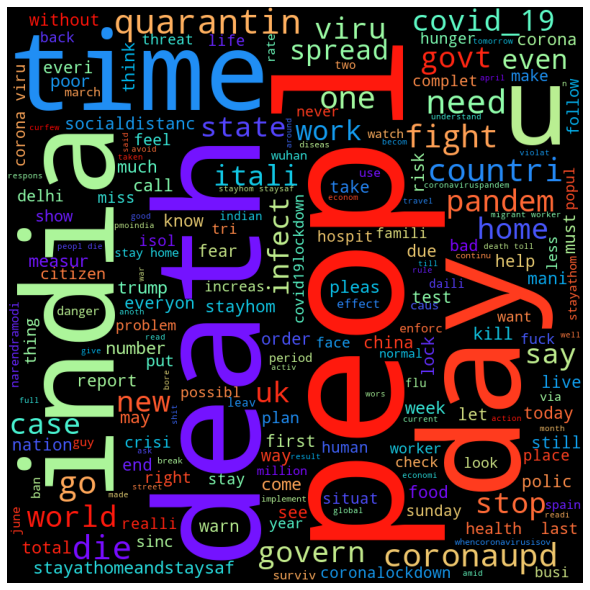

In [30]:
# Negative Sentiment DataFrame

negative = tweets[tweets['sentiment_label'] == 'negative']
generate_word_cloud(negative, 'negative')

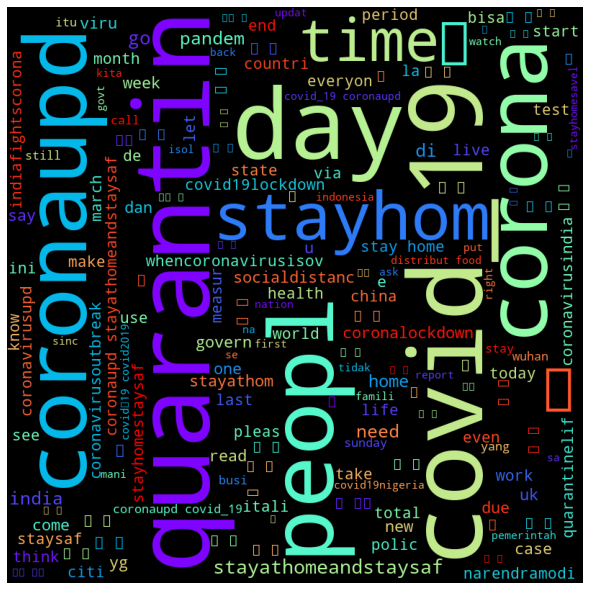

In [31]:
# Neutral Sentiment DataFrame

neutral = tweets[tweets['sentiment_label'] == 'neutral']
generate_word_cloud(neutral, 'neutral')

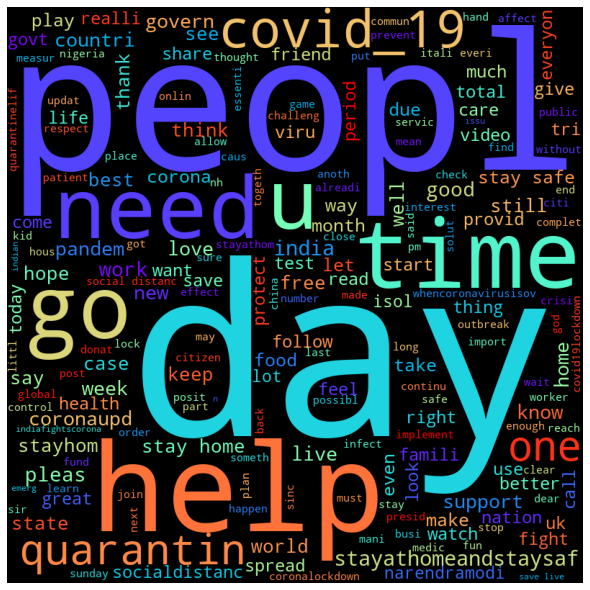

In [32]:
# Positive Sentiment DataFrame

positive = tweets[tweets['sentiment_label'] == 'positive']
generate_word_cloud(positive, 'positive')

In [33]:
# Export to a CSV

# path = "./Twitter_Sentiments/"
# if not os.path.exists(path):
#         os.makedirs(path)

tweets.to_csv('./Twitter_Mar_Sentiments.csv') 

In [39]:
# Check

text = tweets['Text']
for t in text:
    if 'economic' in t:
        print(t)
        print("======================================================================================================")

Indian Prime Minister Modi asked nation's poor for forgiveness, as the economic &amp; human toll from his 21-day nationwide lockdown to combat spread of #COVID19 deepens &amp; criticism mounts over a lack of adequate planning ahead of the decision.

https://t.co/KNBWW4Te41 #coronavirus
The whole world is facing an economic crises because of that unwanted dieseas and Pakistan is shut down due to the curfew and all the industries are sealed and we have no place to earn money so how can we afford our university fee's?
 #IamAStudentNotAnATM #LOCKDOWN #COVID19
Lord God, it's difficult to wrap my head around this reality on ground. #covid19 pandemic is making me numb, so it's real, a global lockdown is here! 😷🤕

My country Nigeria, is never ready for this, just like the economic-wise land border closure for commodities. 

God help us!
@eliasamare Interesting Read!

No doubt z aftermath of #COVID19lockdown will have an adverse effect on society both economically &amp; psychologically.
Some ma